# Single label ResNet training on centralized data

this notebook will show step by step guide to train ResNet single label  

## 1-Loading dependencies

In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## 2-Loading the dataset

load and split the dataset into train and validation using provided pytorch functions

In [2]:

data_dir = './UCMerced_LandUse/images'
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=4)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=4) 
    return {'train': trainloader, 'val': testloader}, {'train': len(train_idx), 'val':len(test_idx)}
dataloaders ,dataset_sizes = load_split_train_test(data_dir, .2)
class_names = dataloaders['train'].dataset.classes
print("the dataset contain the folloing classes:", class_names, " the split sizes:", dataset_sizes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

the dataset contain the folloing classes: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']  the split sizes: {'train': 1680, 'val': 420}


## showing an example of the dataset

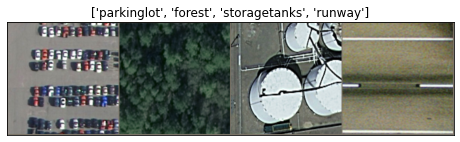

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(8, 8))
    plt.imshow(inp)
    plt.tick_params(axis='both', which='both', length=0, bottom=False,      # ticks along the bottom edge are off
    top=False,labelbottom=False,labelleft=False)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 3-Define a training function
that give back the best model and the statisics of the training 

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    tloss, tacc= [] , []
    vloss, vacc= [] , []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #print(preds, labels.data, running_corrects)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                tloss.append(epoch_loss)
                tacc.append(epoch_acc)
            
            if phase == 'val':
                vloss.append(epoch_loss)
                vacc.append(epoch_acc)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,tloss,tacc,vloss,vacc

## visualization function 
to show the model prediciton vs the true label, with 4 example per line 

In [5]:
def visualize_model(model, num_images=8):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig, axs = plt.subplots(nrows=num_images//4, ncols=4, figsize=(12,8))
    rowindx = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                #ax = plt.subplot(num_images//2, 2, images_so_far)
                #axs[rowindx, images_so_far%4].axis('off')
                #ax.set_title(f'it is {class_names[labels[j]]} and resnet predicted: {class_names[preds[j]]}')
                axs[rowindx, images_so_far%4].set_ylabel(f'True label {class_names[labels[j]]}', fontsize=12)
                axs[rowindx, images_so_far%4].set_xlabel(f'Predicted: {class_names[preds[j]]}', fontsize=12)
                #imshow(inputs.cpu().data[j])
                
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                axs[rowindx, images_so_far%4].imshow(inp)
                
                axs[rowindx, images_so_far%4].set_yticks([])
                axs[rowindx, images_so_far%4].set_xticks([])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
            rowindx +=1
        model.train(mode=was_training)

## 4- Define the training model and parameters 

In [6]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Start the training

In [7]:
model_ft, tloss, tacc, valloss, valacc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.6395 Acc: 0.5077
val Loss: 0.7853 Acc: 0.7619
Epoch 1/24
----------
train Loss: 0.9654 Acc: 0.7119
val Loss: 0.5616 Acc: 0.8286
Epoch 2/24
----------
train Loss: 0.7749 Acc: 0.7685
val Loss: 0.5340 Acc: 0.8619
Epoch 3/24
----------
train Loss: 0.7248 Acc: 0.7756
val Loss: 0.5571 Acc: 0.8500
Epoch 4/24
----------
train Loss: 0.6427 Acc: 0.8095
val Loss: 0.4770 Acc: 0.8690
Epoch 5/24
----------
train Loss: 0.6377 Acc: 0.8107
val Loss: 0.7462 Acc: 0.8548
Epoch 6/24
----------
train Loss: 0.6134 Acc: 0.8226
val Loss: 0.7145 Acc: 0.8119
Epoch 7/24
----------
train Loss: 0.4281 Acc: 0.8714
val Loss: 0.4427 Acc: 0.8786
Epoch 8/24
----------
train Loss: 0.3239 Acc: 0.9054
val Loss: 0.3846 Acc: 0.9048
Epoch 9/24
----------
train Loss: 0.3289 Acc: 0.9024
val Loss: 0.3451 Acc: 0.9167
Epoch 10/24
----------
train Loss: 0.3322 Acc: 0.9060
val Loss: 0.3051 Acc: 0.9190
Epoch 11/24
----------
train Loss: 0.3204 Acc: 0.9077
val Loss: 0.3103 Acc: 0.9238
Epoch 12/24
--

## Plot the loss and accuracy curves

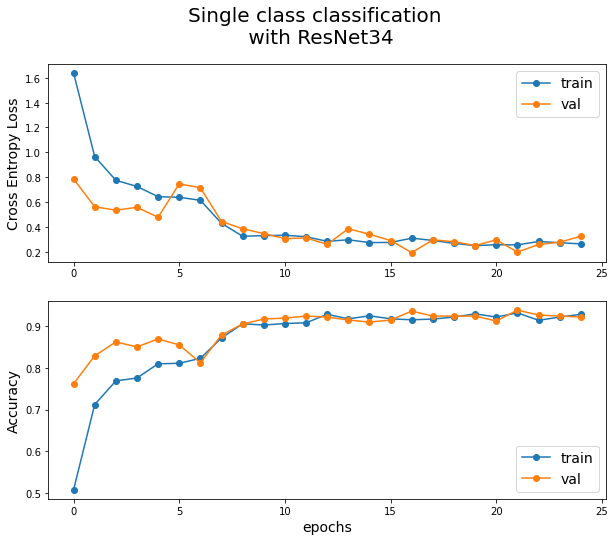

In [22]:
eporange = np.arange(25)
plt.figure(figsize=(10, 8))
plt.suptitle('Single class classification \n with ResNet34',fontsize=20)
plt.ylabel(' Binary Cross Entropy Loss',fontsize=14)
plt.plot(eporange, tloss, 'o-', label='train')
plt.plot(eporange, valloss, 'o-', label='val')
plt.legend(loc='upper right',fontsize=14)


plt.subplot(212)
plt.plot(eporange, tacc, 'o-', label='train')
plt.plot(eporange, valacc, 'o-', label='val')
plt.xlabel('epochs',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.legend(loc='lower right',fontsize=14)
plt.show()

### Visualize some example 

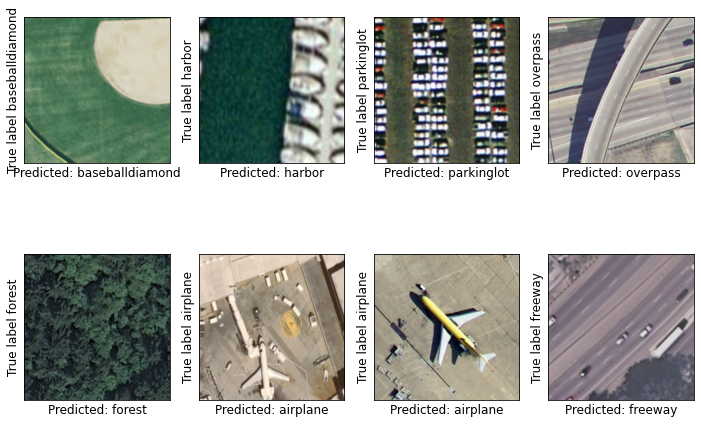

In [30]:
visualize_model(model, 8)

## 5- Save the model

In [34]:
torch.save(model_ft, 'resnet_model.pt')